In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Jan 27 18:43:26 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.999
hp.noise = 1e-4
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.27-5/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 15568
-rw-rw-r-- 1 scpark scpark  978914  1월 27 18:43 events.out.tfevents.1706347711.GPUSVR11
-rw-rw-r-- 1 scpark scpark 7478085  1월 27 18:38 save_5000
-rw-rw-r-- 1 scpark scpark 7471539  1월 27 18:28 save_0
-rw-rw-r-- 1 scpark scpark      40  1월 27 18:28 events.out.tfevents.1706347592.GPUSVR11


In [7]:
# path = '/data/scpark/save/lse/train_dalle/train01.19-7_tanh_0.999_lr1e-4/save_600000'
# checkpoint = torch.load(path, map_location=torch.device('cpu'))
# # warm start
# for i, (model, optimizer) in enumerate(zip(model_list, optimizer_list)):
#     model.load_state_dict(checkpoint['models_state_dict'][i], strict=False)
    
# print('done')

### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

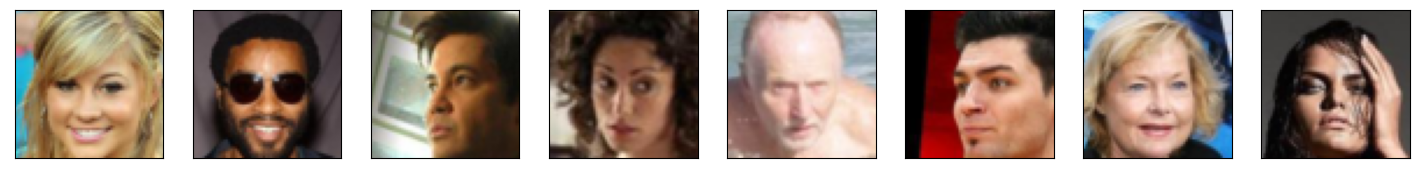

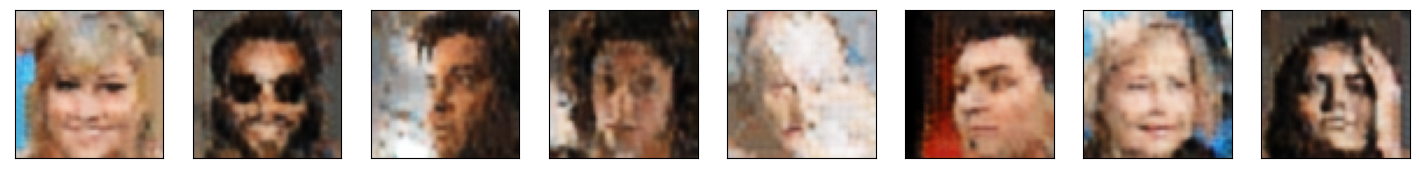

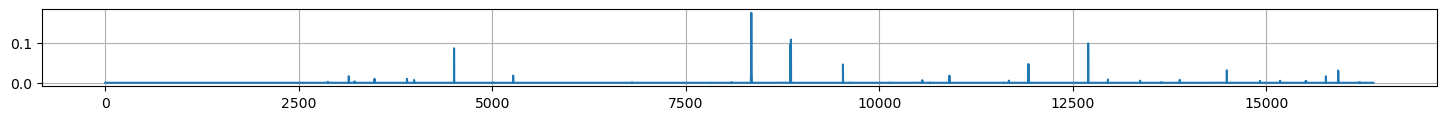

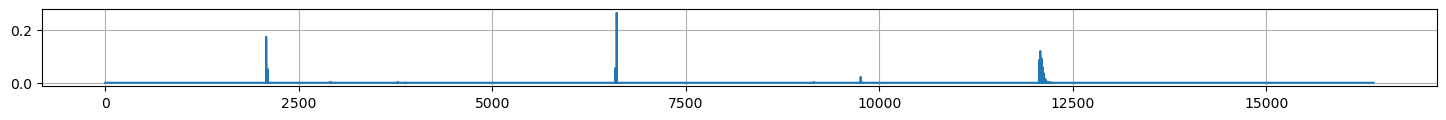

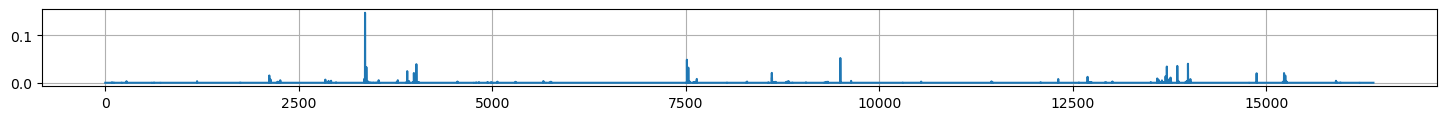

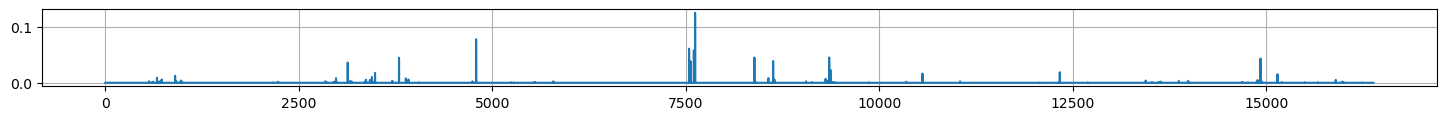

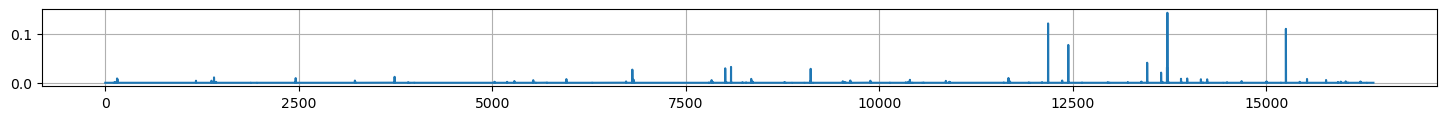

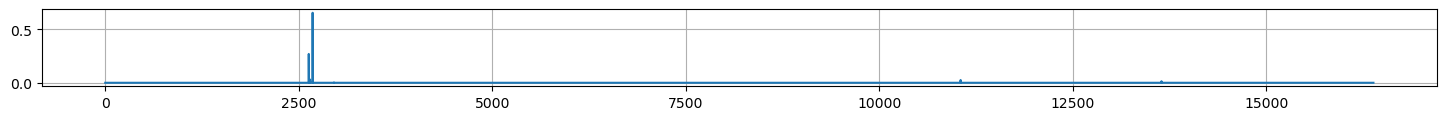

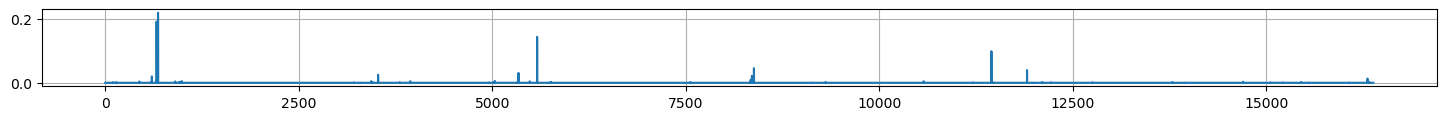

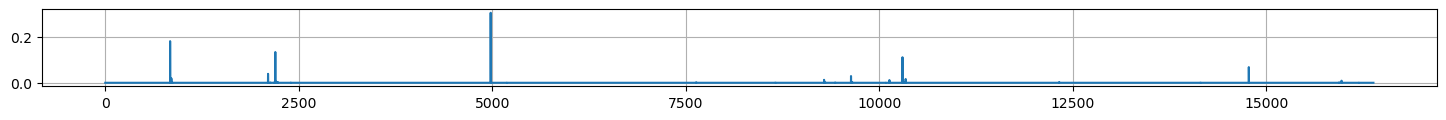

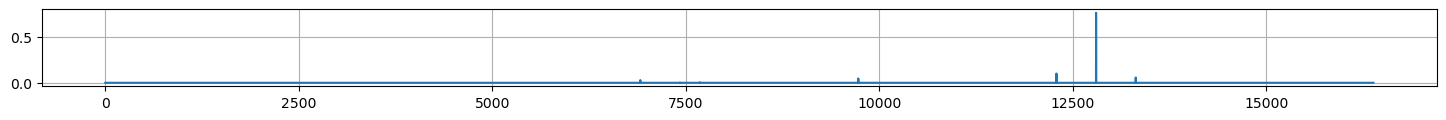

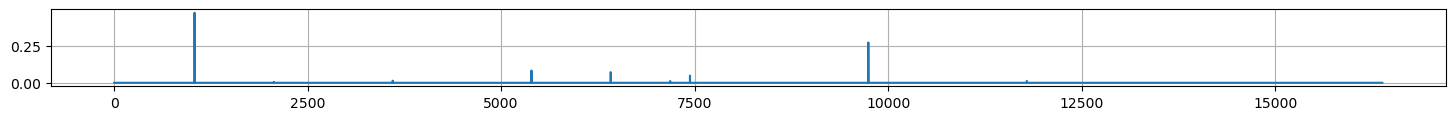

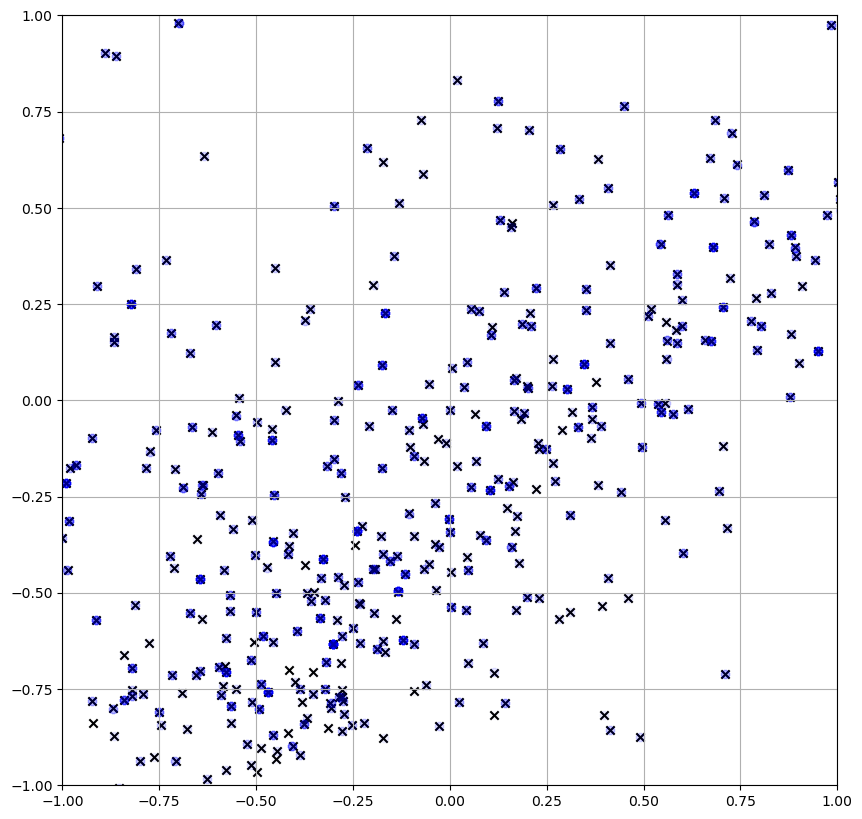

21001
lse_loss -153.49960327148438
commit_loss 0.005153633188456297
recon_loss 0.0005681586917489767
21002
lse_loss -153.3429718017578
commit_loss 0.004993184003978968
recon_loss 0.000702383928000927
21003
lse_loss -153.6154327392578
commit_loss 0.004453903995454311
recon_loss 0.0006162895588204265
21004
lse_loss -153.51010131835938
commit_loss 0.004997314419597387
recon_loss 0.0006002037553116679
21005
lse_loss -153.76019287109375
commit_loss 0.0050473459996283054
recon_loss 0.0006625688401982188
21006
lse_loss -153.6222686767578
commit_loss 0.004929511807858944
recon_loss 0.0008313606958836317
21007
lse_loss -153.57484436035156
commit_loss 0.004983182065188885
recon_loss 0.0006138944299891591
21008
lse_loss -153.71221923828125
commit_loss 0.0049130236729979515
recon_loss 0.0005939349066466093
21009
lse_loss -153.6313934326172
commit_loss 0.0054407198913395405
recon_loss 0.0008017843356356025
21010
lse_loss -153.47625732421875
commit_loss 0.005591380409896374
recon_loss 0.000573307916

lse_loss -154.44960021972656
commit_loss 0.0045267376117408276
recon_loss 0.0005633395630866289
21084
lse_loss -154.14175415039062
commit_loss 0.005022583995014429
recon_loss 0.0005938154645264149
21085
lse_loss -154.06277465820312
commit_loss 0.004728848114609718
recon_loss 0.0005423789261840284
21086
lse_loss -154.02467346191406
commit_loss 0.0051551624201238155
recon_loss 0.0006440992001444101
21087
lse_loss -154.1243896484375
commit_loss 0.004776631947606802
recon_loss 0.0006209582788869739
21088
lse_loss -154.4198455810547
commit_loss 0.0045972103253006935
recon_loss 0.0006365228909999132
21089
lse_loss -154.3218994140625
commit_loss 0.004827361553907394
recon_loss 0.0005947896861471236
21090
lse_loss -154.38052368164062
commit_loss 0.0045780292712152
recon_loss 0.0005416000494733453
21091
lse_loss -153.98150634765625
commit_loss 0.005119528621435165
recon_loss 0.0006531790131703019
21092
lse_loss -154.34141540527344
commit_loss 0.004853896796703339
recon_loss 0.000723143282812088

21166
lse_loss -154.7005157470703
commit_loss 0.004735087975859642
recon_loss 0.0005920012481510639
21167
lse_loss -154.57135009765625
commit_loss 0.004750864580273628
recon_loss 0.0006612902507185936
21168
lse_loss -154.8462371826172
commit_loss 0.004475053399801254
recon_loss 0.000637369928881526
21169
lse_loss -154.71969604492188
commit_loss 0.004870099015533924
recon_loss 0.0005711573176085949
21170
lse_loss -154.93568420410156
commit_loss 0.004712994210422039
recon_loss 0.0006084038177505136
21171
lse_loss -154.86065673828125
commit_loss 0.004719150718301535
recon_loss 0.0006690860609523952
21172
lse_loss -154.6953887939453
commit_loss 0.004687000066041946
recon_loss 0.0006027694907970726
21173
lse_loss -154.96575927734375
commit_loss 0.0043137636967003345
recon_loss 0.0006302553229033947
21174
lse_loss -154.4937744140625
commit_loss 0.005412675905972719
recon_loss 0.0006657707272097468
21175
lse_loss -155.005859375
commit_loss 0.004475864581763744
recon_loss 0.0006066127680242062

21248
lse_loss -155.04489135742188
commit_loss 0.005396140273660421
recon_loss 0.0008420649683102965
21249
lse_loss -155.29039001464844
commit_loss 0.0044693960808217525
recon_loss 0.000576577614992857
21250
lse_loss -154.4589385986328
commit_loss 0.005201947875320911
recon_loss 0.0007400559261441231
21251
lse_loss -155.28981018066406
commit_loss 0.004415244795382023
recon_loss 0.0007185759022831917
21252
lse_loss -155.14242553710938
commit_loss 0.004756662994623184
recon_loss 0.0008833945612423122
21253
lse_loss -155.06005859375
commit_loss 0.005078156478703022
recon_loss 0.0005717889871448278
21254
lse_loss -155.1999053955078
commit_loss 0.0043264348059892654
recon_loss 0.0005567140178754926
21255
lse_loss -154.6336669921875
commit_loss 0.00467078760266304
recon_loss 0.0005931591149419546
21256
lse_loss -155.3068084716797
commit_loss 0.004521794617176056
recon_loss 0.0006994958384893835
21257
lse_loss -155.32757568359375
commit_loss 0.004988169297575951
recon_loss 0.00066834350582212

lse_loss -155.64590454101562
commit_loss 0.005179510451853275
recon_loss 0.0005707271629944444
21331
lse_loss -155.7867889404297
commit_loss 0.0044230688363313675
recon_loss 0.0005974745145067573
21332
lse_loss -155.8136749267578
commit_loss 0.00482808705419302
recon_loss 0.0006239210488274693
21333
lse_loss -155.80946350097656
commit_loss 0.004774690605700016
recon_loss 0.0006525572389364243
21334
lse_loss -155.71263122558594
commit_loss 0.004653123207390308
recon_loss 0.0007999764638952911
21335
lse_loss -155.70741271972656
commit_loss 0.004492551553994417
recon_loss 0.000556856335606426
21336
lse_loss -155.6102294921875
commit_loss 0.004730171523988247
recon_loss 0.0006002578884363174
21337
lse_loss -155.3140106201172
commit_loss 0.004861047957092524
recon_loss 0.0006110522663220763
21338
lse_loss -155.83287048339844
commit_loss 0.004835177678614855
recon_loss 0.0006044947076588869
21339
lse_loss -155.76048278808594
commit_loss 0.004934455268085003
recon_loss 0.0006375607335940003
2

21413
lse_loss -156.19992065429688
commit_loss 0.004801985342055559
recon_loss 0.0006341753178276122
21414
lse_loss -156.24374389648438
commit_loss 0.004365510307252407
recon_loss 0.0005993950180709362
21415
lse_loss -156.42625427246094
commit_loss 0.00451119989156723
recon_loss 0.0005969070480205119
21416
lse_loss -156.1289520263672
commit_loss 0.004701490048319101
recon_loss 0.0006364516448229551
21417
lse_loss -156.50448608398438
commit_loss 0.004514235071837902
recon_loss 0.0005944091826677322
21418
lse_loss -155.85971069335938
commit_loss 0.0050926972180604935
recon_loss 0.0006200430216267705
21419
lse_loss -156.34323120117188
commit_loss 0.004478998947888613
recon_loss 0.0005307312239892781
21420
lse_loss -156.37530517578125
commit_loss 0.004087798297405243
recon_loss 0.0005653875414282084
21421
lse_loss -156.454833984375
commit_loss 0.0045666806399822235
recon_loss 0.000630469061434269
21422
lse_loss -156.29759216308594
commit_loss 0.004622955806553364
recon_loss 0.0006009579519

lse_loss -156.75999450683594
commit_loss 0.004652689676731825
recon_loss 0.000578755687456578
21496
lse_loss -156.87315368652344
commit_loss 0.004619820974767208
recon_loss 0.0006917623686604202
21497
lse_loss -156.99838256835938
commit_loss 0.004596828017383814
recon_loss 0.0006243006209842861
21498
lse_loss -156.42913818359375
commit_loss 0.004627884365618229
recon_loss 0.0006433848175220191
21499
lse_loss -156.67103576660156
commit_loss 0.004868905991315842
recon_loss 0.0007234262302517891
21500
lse_loss -156.6849822998047
commit_loss 0.004434945993125439
recon_loss 0.0006663942476734519
21501
lse_loss -156.66993713378906
commit_loss 0.005420021712779999
recon_loss 0.0009252420859411359
21502
lse_loss -156.95431518554688
commit_loss 0.00428466871380806
recon_loss 0.0007592970505356789
21503
lse_loss -156.814697265625
commit_loss 0.004517144523561001
recon_loss 0.0006080630118958652
21504
lse_loss -156.67921447753906
commit_loss 0.0048579322174191475
recon_loss 0.000605048961006105
2

21578
lse_loss -157.35177612304688
commit_loss 0.004809600301086903
recon_loss 0.0007039138581603765
21579
lse_loss -157.25711059570312
commit_loss 0.0048788851127028465
recon_loss 0.000622302177362144
21580
lse_loss -157.26437377929688
commit_loss 0.004604389891028404
recon_loss 0.0006160608027130365
21581
lse_loss -157.547607421875
commit_loss 0.004083492327481508
recon_loss 0.0007392390398308635
21582
lse_loss -157.46372985839844
commit_loss 0.004392680712044239
recon_loss 0.0005866520805284381
21583
lse_loss -157.1587677001953
commit_loss 0.004501085262745619
recon_loss 0.0005883489502593875
21584
lse_loss -157.25732421875
commit_loss 0.004585218615829945
recon_loss 0.0005871729226782918
21585
lse_loss -157.40419006347656
commit_loss 0.0047182608395814896
recon_loss 0.0006229797145351768
21586
lse_loss -156.89688110351562
commit_loss 0.004758359864354134
recon_loss 0.0007657611276954412
21587
lse_loss -157.34120178222656
commit_loss 0.00449366495013237
recon_loss 0.0006602217326872

21660
lse_loss -157.9004364013672
commit_loss 0.004807900171726942
recon_loss 0.0006765901925973594
21661
lse_loss -157.76092529296875
commit_loss 0.004319896921515465
recon_loss 0.0006766258738934994
21662
lse_loss -157.5990447998047
commit_loss 0.0047483257949352264
recon_loss 0.0005971055943518877
21663
lse_loss -157.91123962402344
commit_loss 0.004447593353688717
recon_loss 0.0006149874534457922
21664
lse_loss -157.76522827148438
commit_loss 0.004002075642347336
recon_loss 0.000623908534180373
21665
lse_loss -157.85787963867188
commit_loss 0.004407634027302265
recon_loss 0.0005963523872196674
21666
lse_loss -157.82899475097656
commit_loss 0.004159056581556797
recon_loss 0.0006874522077850997
21667
lse_loss -158.0507354736328
commit_loss 0.003729437477886677
recon_loss 0.0005450911121442914
21668
lse_loss -157.9578094482422
commit_loss 0.00412399647757411
recon_loss 0.0006721186218783259
21669
lse_loss -157.8426513671875
commit_loss 0.004173366352915764
recon_loss 0.0006026225746609

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)
            
            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 100 == 0:
            loss_dict = {}
            for model in model_list:
                data = preprocess(batch)
                
                # Forward
                model.eval()
                with torch.no_grad():
                    data = model(data, latent_temp=1, quantize=True)

                for key in data.keys():
                    if 'loss' in key:
                        if key in loss_dict:
                            loss_dict[key].append(data[key].item())
                        else:
                            loss_dict[key] = [data[key].item()]
                        
            writer.add_scalar('eval_recon_loss', np.mean(loss_dict['recon_loss']), step)
            
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')